## Language Translator

In [37]:
import nltk
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [39]:
from tensorflow.keras.utils import to_categorical
import joblib
import numpy as np
from nltk.corpus import comtrans

From `nltk` we can download translated sentences between different languages. You can see the example between **English and French** below but feel free to try different combination as well.

In [ ]:
nltk.download('comtrans')

[nltk_data] Downloading package comtrans to
[nltk_data]     /home/ryanvan611/nltk_data...


True

In [ ]:

print(comtrans.aligned_sents('alignment-en-fr.txt')[0])

<AlignedSent: 'Resumption of the se...' -> 'Reprise de la sessio...'>


In [ ]:
len(comtrans.aligned_sents('alignment-en-fr.txt'))

33334

In [ ]:
eng_text = []
frn_text = []
eng_max = 0
frn_max = 0
for i in range(33334):
    als = comtrans.aligned_sents("alignment-en-fr.txt")[i]
    if len(als.words) > eng_max:
        eng_max = len(als.words) 
    if len(als.mots) > frn_max:
        frn_max = len(als.mots) 
    eng_text.append(" ".join(als.words))
    frn_text.append(" ".join(als.mots))
print(len(eng_text), 'and', eng_max)
print(len(frn_text), 'and', eng_max)

In [ ]:
joblib.dump(eng_text, 'eng_text.joblib')
joblib.dump(frn_text, 'frn_text.joblib')

['frn_text.joblib']

In [4]:
frn_text = joblib.load('frn_text.joblib')
eng_text = joblib.load('eng_text.joblib')

In [4]:
len(eng_text)

31500

In [5]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
length = max([len(sentence) for sentence in frn_text])

In [ ]:
length

282

In [6]:
# prepare english tokenizer
eng_tokenizer = tokenization(eng_text)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 40
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 15553


In [7]:
# prepare french tokenizer
frn_tokenizer = tokenization(frn_text)
frn_vocab_size = len(frn_tokenizer.word_index) + 1

frn_length = 40
print('French Vocabulary Size: %d' % frn_vocab_size)

French Vocabulary Size: 21326


In [8]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split( frn_text, eng_text, test_size=0.2, random_state=12)

In [12]:
len(X_train)

25200

In [13]:
# prepare training data
trainX = encode_sequences(frn_tokenizer,frn_length, X_train)
trainY = encode_sequences(eng_tokenizer, eng_length, y_train)

# prepare validation data
testX = encode_sequences(frn_tokenizer, frn_length, X_test)
testY = encode_sequences(eng_tokenizer, eng_length, y_test)

In [24]:
testX.shape

(6300, 40)

In [25]:
valid_X = testX[:5]

In [15]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [16]:
# model compilation
model = define_model(frn_vocab_size, eng_vocab_size, frn_length, eng_length, 512)

In [18]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [68]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=1000, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
21/21 [==============================] - 98s 2s/step - loss: 2.8547 - val_loss: 3.1283

Epoch 00001: val_loss improved from inf to 3.12826, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 2/30
21/21 [==============================] - 50s 2s/step - loss: 2.7834 - val_loss: 3.1298

Epoch 00002: val_loss did not improve from 3.12826
Epoch 3/30
21/21 [==============================] - 46s 2s/step - loss: 2.7657 - val_loss: 3.1807

Epoch 00003: val_loss did not improve from 3.12826
Epoch 4/30
21/21 [==============================] - 52s 2s/step - loss: 2.7586 - val_loss: 3.1605

Epoch 00004: val_loss did not improve from 3.12826
Epoch 5/30
21/21 [==============================] - 51s 2s/step - loss: 2.7474 - val_loss: 3.1288

Epoch 00005: val_loss did not improve from 3.12826
Epoch 6/30
21/21 [==============================] - 48s 2s/step - loss: 2.7342 - val_loss: 3.1540

Epoch 00006: val_loss did not improve from 3.12826
Epoch 7/30
21/21 [==============================] - 50s 2s/step - loss: 2.7237 - val_loss: 3.1653

Epoch 00007: val_loss did not improve from 3.12826
Epoch 8/30
21/21 [==============================] - 47s 2s/step - loss: 2.7052 - val_loss: 3.1503

E

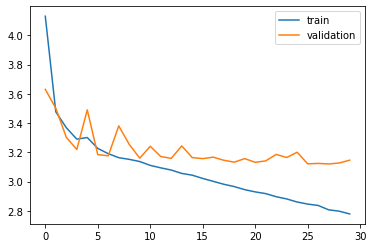

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model.weights[0]

<tf.Variable 'embedding_1/embeddings:0' shape=(3441, 512) dtype=float32, numpy=
array([[-0.03191042,  0.02126977, -0.01851431, ...,  0.02034804,
        -0.02166078, -0.00296025],
       [ 0.00749052,  0.01633582,  0.00320757, ...,  0.03766687,
        -0.01713919,  0.01101888],
       [-0.02866866, -0.03106461, -0.01761603, ..., -0.00773163,
         0.03964704,  0.01011656],
       ...,
       [ 0.04316159, -0.00984835, -0.01823862, ..., -0.00216317,
         0.04605131,  0.02453344],
       [ 0.04976709,  0.02827932,  0.04133967, ..., -0.03708106,
         0.00869862,  0.0070174 ],
       [-0.04477631, -0.04700129,  0.02558156, ..., -0.04385519,
         0.00310589,  0.04713909]], dtype=float32)>

In [40]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

AttributeError: ignored

In [51]:
predictions = (model.predict(valid_X) > 0.5).astype("int32")

In [52]:
predictions.shape

(5, 40, 15553)

In [48]:
preds = model.predict(valid_X.reshape((valid_X.shape[0],valid_X.shape[1])))

In [49]:
classes_x=np.argmax(preds,axis=-1)

In [53]:
classes_x.shape

(5, 40)

In [58]:
preds[0,0]

array([5.3313332e-08, 5.2679558e-03, 1.5752482e-04, ..., 3.9524326e-07,
       8.4596635e-08, 3.6412661e-07], dtype=float32)

In [66]:
max = 0
count =0
for i in range(len(preds[0,10])):
  if preds[0,10][i] > max:
    max = preds[0,10][i] 
    count = i


In [67]:
print(max, count)

0.08533305 1


In [63]:
classes_x[0,10]

1

In [21]:
## load model from history
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

AttributeError: ignored

In [30]:
## from ids to words
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [54]:
preds_text = []
for i in classes_x:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [55]:
pred_df = pd.DataFrame({'actual' : y_test[:5], 'predicted' : preds_text})

In [56]:
pred_df

,actual,predicted
0,"Madam President , we have read in the newspapers that five million euros ' worth of Parliament property has been purloined and that Parliament ' s finances have been poorly managed .",mr president i to the
1,"What is important , however , is that they have begun .",we are to the
2,But why do they not buy their own entrance ticket ?,we to
3,"The fight by feedingstuff manufacturers to gain maximum market shares causes a lot of problems , just as it does in the foodstuffs industry .",the of the
4,The very political essence of the reform is mirrored in the objectives of this five-year plan .,this is to the
